# Python Intermedio - Sesión 8

![logo](https://www.belatrix.com/wp-content/uploads/2023/08/belatrix-logosweb-1.png)

# Bases de Datos (SQLite 3)

SQLite 3 es un tipo de base de datos SQL que se encuentra de forma nativa en Python (en las versiones más recientes). De tal modo que podemos hacer pruebas locales, antes de consumir un conector a bases de datos remotas, por ejemplo, Oracle SQL, SQLServer, MySQL o PostgreSQL.

In [43]:
import sqlite3

sqlite3.version

'2.6.0'

## Conector a la base datos

El conector establece una conexión a la base de datos (en SQLite la conexión es local a un archivo y en otros motores, la conexión sería remota a un servidor o a un puerto de la computadora).

In [44]:
conn = sqlite3.connect("prueba.db")

#conn.close()

## Cursor

El cursor representa un objeto capaz de ejecutar sentencias (lanzar queries/consultas) y adquirir los resultados.

Hay dos tipos de sentencias que podemos hacer:

* `SELECT` - Se consideran de lectura, por lo que no necesitan avisarle a la conexión que hay cambios pendiente
* `INSERT / UPDATE / DELETE / CREATE` - Se consideran de escritura (tienen un efecto en la base de datos), por que sí necistan avisarle a la conexión que hay pendientes y los procese (enviar a la base de datos)

Al crear tablas y definir los campos de la tabla, podemos utilizar los siguientes tipos de datos para retener información:

* `INTEGER` - Un número entero
* `REAL` - Un número decimal
* `TEXT` - Un texto
* `BLOB` - Bytes o archivos binarios
* `BOOLEAN` - Es un número entero (0 y 1)

In [45]:
cursor = conn.cursor()

cursor.execute("""

CREATE TABLE IF NOT EXISTS pruebas (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  nombre TEXT NOT NULL,
  mensaje TEXT DEFAULT 'Sin mensaje'
)

""")

# IMPORTE: Como es una consulta de escritura (CREATE)
# debemos notificar el envío a la base de datos: HACER COMMIT
conn.commit()

cursor.close()

## Insertar nuevos valores

Las bases de datos se orginazan en tablas y las tablas en registros, entonces, para insertar un registro haremos uso de `INSERT INTO` para insertar los valores obligatorios al menos y eso formará un nuevo registro con su identificador.

```sql
INSERT INTO <tabla> (<campos>) VALUES (<valores>)
```

In [46]:
cursor = conn.cursor()

cursor.execute("INSERT INTO pruebas (nombre, mensaje) VALUES (?, ?)",
  ("Prueba 1", "Hola esta es la primera prueba"))

# IMPORTANTE: INSERT es una consulta de tipo escritura,
# por lo que debemos HACER COMMIT
conn.commit()

cursor.close()

> Ejercicio: Hacer que el usuario ingrese los datos de la prueba

In [47]:
cursor = conn.cursor()

nombre = input("Nombre: ")
mensaje = input("Mensaje: ")

cursor.execute("INSERT INTO pruebas (nombre, mensaje) VALUES (?, ?)",
  (nombre, mensaje))

# IMPORTANTE: INSERT es una consulta de tipo escritura,
# por lo que debemos HACER COMMIT
conn.commit()

cursor.close()

Nombre: Hola
Mensaje: mundo


## Consultar *todos* los valores

Para recuperar los registros de una tabla usaremos `SELECT` y podrémos recuperar cada registro que equivale a una tupla de los campos seleccionados, por ejemplo, si se seleccionan 2 campos, podremos iterar una 2-tupla, y así sucesivamente.

```sql
SELECT <campos> FROM <tabla>
```

In [48]:
cursor = conn.cursor()

cursor.execute("SELECT id, nombre, mensaje FROM pruebas")

# El cursor ejecuta la consulta,
# pero ahora hay que recuperar los resultados
# mediante alguna estrategia fetch*, por ejemplo, `fetchall`
pruebas = cursor.fetchall()

print(pruebas)

cursor.close()

[(1, 'Prueba 1', 'Hola esta es la primera prueba'), (2, 'Hola', 'mundo')]


**Nota**: Los resultados de `fetchall()` es una lista de $k$-tuplas, para los $k$ campos consultados. Por ejemplo, si solicitamos 3 campos, tendremos una lista de 3-tuplas.

In [49]:
for id, nombre, mensaje in pruebas:
  print(f"[{id:04d}] {nombre:20}")
  print(f">>> {mensaje}")
  print()

[0001] Prueba 1            
>>> Hola esta es la primera prueba

[0002] Hola                
>>> mundo



> Ejercicio: Mostrar las pruebas con pandas

In [50]:
import pandas

data = pandas.DataFrame(pruebas, columns=["ID", "Nombre", "Mensaje"]).set_index("ID")

data.head()

,Nombre,Mensaje
ID,,
1,Prueba 1,Hola esta es la primera prueba
2,Hola,mundo


## Caso de uso: Simulador de Ventas

In [63]:
import sqlite3
import numpy
import pandas
import seaborn
import matplotlib.pyplot as pyplot

In [64]:
conn = sqlite3.connect("ventas.db")

In [65]:
cursor = conn.cursor()

cursor.execute("""

CREATE TABLE IF NOT EXISTS clientes (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  nombre TEXT NOT NULL,
  sexo TEXT NOT NULL,
  edad INTEGER NOT NULL,
  casado INTEGER NOT NULL
)

""")

cursor.execute("""

CREATE TABLE IF NOT EXISTS productos (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  nombre TEXT NOT NULL,
  precio REAL NOT NULL,
  departamento TEXT NOT NULL,
  categoria TEXT NOT NULL
)

""")

cursor.execute("""

CREATE TABLE IF NOT EXISTS ventas (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  id_cliente INTEGER NOT NULL,
  fecha TEXT NOT NULL
)

""")

cursor.execute("""

CREATE TABLE IF NOT EXISTS venta_producto (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  id_venta INTEGER NOT NULL,
  id_producto INTEGER NOT NULL
)

""")

conn.commit()

cursor.close()

In [66]:
def crearCliente(nombre, sexo, edad, casado):
  cursor = conn.cursor()

  cursor.execute("INSERT INTO clientes (nombre, sexo, edad, casado) "\
                 "VALUES (?, ?, ?, ?)", (nombre, sexo, edad, casado))

  conn.commit()

  cursor.close()

In [55]:
# crearCliente("Prueba 1", "ROBOT", 23, False)

In [67]:
nombres_masculinos = ["Alberto", "Benito", "Carlos", "Daniel", "Eduardo"]
nombres_femeninos = ["Ana", "Beatriz", "Carla", "Daniela", "Edna"]
apellidos = ["Ávila", "Benitez", "Camacho", "Díaz", "Espinoza"]

for i in range(100):
  sexo = numpy.random.choice(["HOMBRE", "MUJER"])

  if sexo == "HOMBRE":
    nombre = numpy.random.choice(nombres_masculinos)
  else:
    nombre = numpy.random.choice(nombres_femeninos)

  apellidoPaterno = numpy.random.choice(apellidos)
  apellidoMaterno = numpy.random.choice(apellidos)

  if sexo == "HOMBRE":
    edad = numpy.random.normal(30, 6)
  else:
    edad = numpy.random.normal(25, 15)

  if edad <= 18:
    edad += numpy.random.uniform(18, 30)

  edad = int(edad)

  if sexo == "HOMBRE":
    if edad < 24:
      casado = numpy.random.choice([True, False], p=[0.1, 0.9])
    elif edad >= 24 and edad < 30:
      casado = numpy.random.choice([True, False], p=[0.3, 0.7])
    elif edad >= 30 and edad < 40:
      casado = numpy.random.choice([True, False], p=[0.8, 0.2])
    elif edad >= 40 and edad < 50:
      casado = numpy.random.choice([True, False], p=[0.5, 0.5])
    elif edad >= 50:
      casado = numpy.random.choice([True, False], p=[0.7, 0.3])
  else:
    if edad < 24:
      casado = numpy.random.choice([True, False], p=[0.2, 0.8])
    elif edad >= 24 and edad < 30:
      casado = numpy.random.choice([True, False], p=[0.4, 0.6])
    elif edad >= 30 and edad < 40:
      casado = numpy.random.choice([True, False], p=[0.9, 0.1])
    elif edad >= 40 and edad < 50:
      casado = numpy.random.choice([True, False], p=[0.6, 0.4])
    elif edad >= 50:
      casado = numpy.random.choice([True, False], p=[0.4, 0.6])

  casado = bool(casado)

  crearCliente(f"{nombre} {apellidoPaterno} {apellidoMaterno}", sexo, edad, casado)

In [68]:
def obtenerClientes():
  cursor = conn.cursor()
  cursor.execute("SELECT id, nombre, sexo, edad, casado FROM clientes")
  clientes = cursor.fetchall()
  cursor.close()
  return clientes

In [69]:
obtenerClientes()

[(1, 'Carla Ávila Camacho', 'MUJER', 55, 0),
 (2, 'Carlos Camacho Benitez', 'HOMBRE', 34, 1),
 (3, 'Daniela Camacho Espinoza', 'MUJER', 42, 1),
 (4, 'Benito Ávila Benitez', 'HOMBRE', 35, 1),
 (5, 'Daniela Camacho Benitez', 'MUJER', 22, 1),
 (6, 'Edna Benitez Díaz', 'MUJER', 28, 0),
 (7, 'Benito Benitez Ávila', 'HOMBRE', 27, 0),
 (8, 'Eduardo Espinoza Camacho', 'HOMBRE', 37, 1),
 (9, 'Beatriz Espinoza Benitez', 'MUJER', 32, 1),
 (10, 'Daniel Benitez Espinoza', 'HOMBRE', 33, 0),
 (11, 'Benito Ávila Benitez', 'HOMBRE', 27, 0),
 (12, 'Alberto Díaz Ávila', 'HOMBRE', 41, 1),
 (13, 'Alberto Benitez Díaz', 'HOMBRE', 29, 0),
 (14, 'Alberto Camacho Benitez', 'HOMBRE', 30, 1),
 (15, 'Ana Benitez Camacho', 'MUJER', 43, 1),
 (16, 'Edna Ávila Benitez', 'MUJER', 21, 1),
 (17, 'Ana Camacho Camacho', 'MUJER', 24, 1),
 (18, 'Alberto Ávila Camacho', 'HOMBRE', 26, 0),
 (19, 'Ana Ávila Espinoza', 'MUJER', 62, 0),
 (20, 'Ana Díaz Ávila', 'MUJER', 46, 1),
 (21, 'Edna Espinoza Benitez', 'MUJER', 22, 0),
 (22,

In [70]:
clientes = pandas.DataFrame(obtenerClientes(),
                            columns=["ID", "Nombre", "Sexo", "Edad", "Casado"])

clientes = clientes.set_index("ID")

clientes.head()

,Nombre,Sexo,Edad,Casado
ID,,,,
1,Carla Ávila Camacho,MUJER,55,0
2,Carlos Camacho Benitez,HOMBRE,34,1
3,Daniela Camacho Espinoza,MUJER,42,1
4,Benito Ávila Benitez,HOMBRE,35,1
5,Daniela Camacho Benitez,MUJER,22,1


In [72]:
clientes["Sexo"].value_counts()

,count
Sexo,
MUJER,55
HOMBRE,45


<Axes: ylabel='Frequency'>

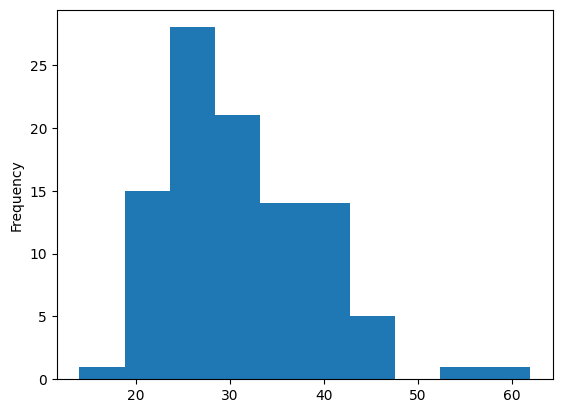

In [76]:
clientes["Edad"].plot.hist()

In [77]:
clientes["Casado"].value_counts()

,count
Casado,
1,52
0,48


<Axes: xlabel='Edad', ylabel='Count'>

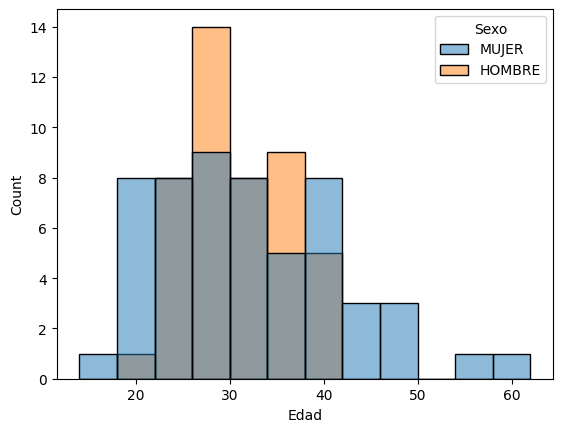

In [79]:
seaborn.histplot(clientes, x="Edad", hue="Sexo")

<Axes: xlabel='Sexo', ylabel='Edad'>

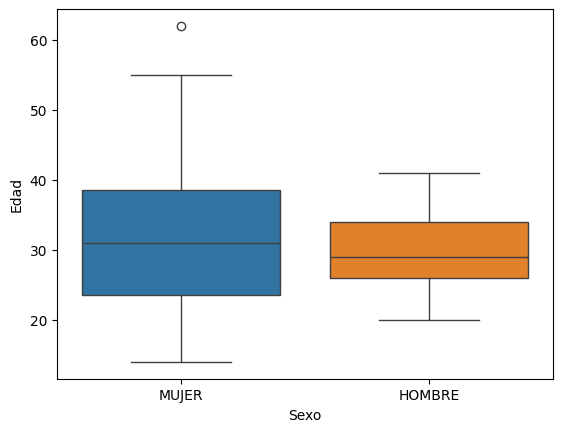

In [85]:
seaborn.boxplot(clientes, x="Sexo", y="Edad", hue="Sexo")

<Axes: xlabel='Casado', ylabel='Edad'>

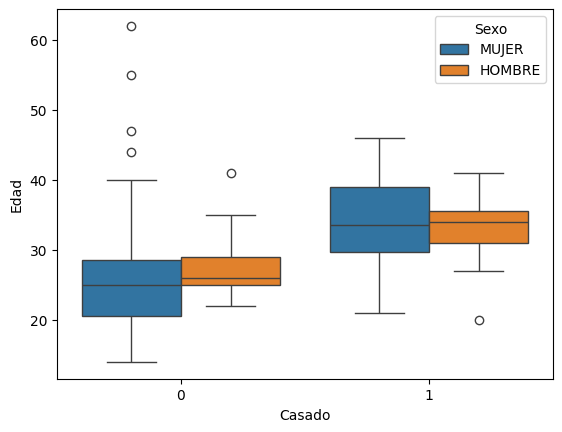

In [86]:
seaborn.boxplot(clientes, x="Casado", y="Edad", hue="Sexo")